## Iterative Closest Point

In [245]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2

def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

pc_1 = np.array([
    [random.randint(0, 20), random.randint(0, 20)]
    for _ in range(20)
])
pc_2 = np.array([rotate((0,0), (x + 10 + random.random(), y + 10 + random.random()), math.pi / 16) for x, y in pc_1])

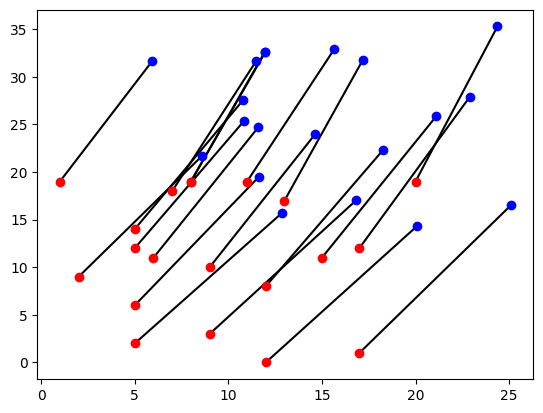

In [247]:
for pt1, pt2 in zip(pc_1, pc_2):
    plt.plot(*list(zip(pt1, pt2)), c="black", zorder=1)

plt.scatter(*list(zip(*pc_1)), c="red", zorder=2)
plt.scatter(*list(zip(*pc_2)), c="blue", zorder=2)

In [248]:
def calculate_correspondences(pc_1, pc_2):
    sq_dist = lambda p1, p2: (p2[1] - p1[1]) ** 2 + (p2[0] - p1[0]) ** 2
    correspondences = []
    for pt in pc_1:
        closest_point = min(pc_2, key=lambda x: sq_dist(pt, x))
        correspondences.append(closest_point)
    return np.array(correspondences)

calculate_correspondences(pc_1, pc_2)

array([[20.10125017, 14.35398138],
       [20.10125017, 14.35398138],
       [11.64996422, 19.52266889],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [ 8.56789069, 21.6403242 ],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [ 8.56789069, 21.6403242 ],
       [ 8.56789069, 21.6403242 ],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [12.87168127, 15.70457289],
       [ 8.56789069, 21.6403242 ],
       [18.24526844, 22.2569406 ],
       [12.87168127, 15.70457289]])

In [249]:
matrix, inliers = cv2.estimateAffine2D(pc_1, pc_2)

# Extract the rotation and translation components
rotation_matrix = matrix[:, :2]
translation_vector = matrix[:, 2]

print("Affine Transformation Matrix:\n", matrix)
print("Rotation Matrix:\n", rotation_matrix)
print("Translation Vector:\n", translation_vector)

Affine Transformation Matrix:
 [[ 0.99120524 -0.20368384  8.25286312]
 [ 0.17924246  0.99299419 12.48706762]]
Rotation Matrix:
 [[ 0.99120524 -0.20368384]
 [ 0.17924246  0.99299419]]
Translation Vector:
 [ 8.25286312 12.48706762]


In [250]:
matrix

array([[ 0.99120524, -0.20368384,  8.25286312],
       [ 0.17924246,  0.99299419, 12.48706762]])

In [251]:
def transform_pc(pc, affine_transform_mat):
    return cv2.transform(np.array([pc]).astype(np.float32), affine_transform_mat)[0]

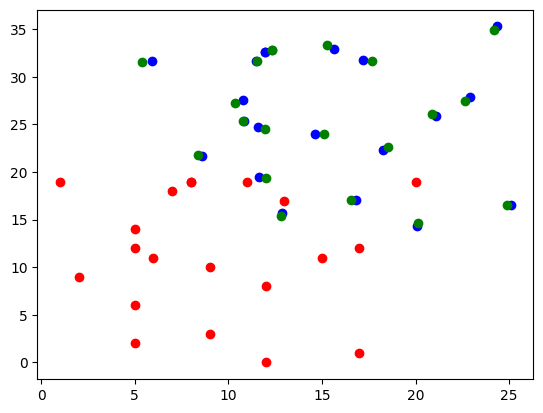

In [252]:
plt.scatter(*list(zip(*pc_1)), c="red")
plt.scatter(*list(zip(*pc_2)), c="blue")
plt.scatter(*list(zip(*transform_pc(pc_1, matrix))), c="green")

In [253]:
pc_1.shape

(20, 2)

In [275]:
def icp(pc_1, pc_2, num_iters=10):
    result_pc, corr_pc_2 = pc_1.astype(np.float32).copy(), pc_2.astype(np.float32)
    pcs = []
    for _ in range(num_iters):
        corr_pc_2 = calculate_correspondences(result_pc, pc_2)
        result_pc, rotation_matrix, translation_vector = procrustes_analysis(result_pc, corr_pc_2)
        pcs.append(result_pc)

        print("SSE:", np.sum((result_pc - corr_pc_2) ** 2))

    return result_pc, pcs

In [276]:
new_pc, pcs = icp(pc_1, pc_2)

SSE: 673.8576757844276
SSE: 284.9694565864415
SSE: 187.34522879762247
SSE: 147.7786707349095
SSE: 145.32272764004452
SSE: 134.48286414719396
SSE: 119.73029449235663
SSE: 107.68954808107094
SSE: 107.68954808107098
SSE: 107.68954808107104


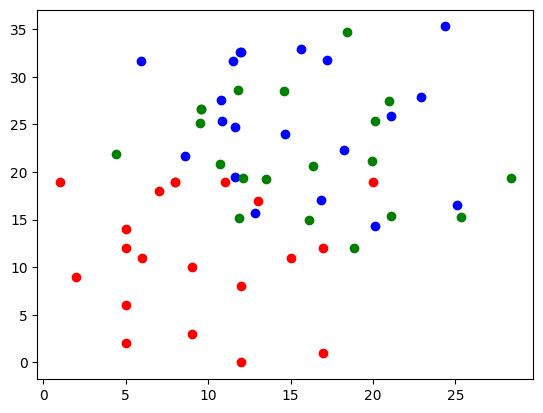

In [277]:
plt.scatter(*list(zip(*pc_1)), c="red")
plt.scatter(*list(zip(*pc_2)), c="blue")
plt.scatter(*list(zip(*new_pc)), c="green")

Transformed Points1:
 [[26.30211326 21.54527415]
 [19.04643565 22.14121245]
 [21.60394452 29.7870707 ]
 [15.32905219 30.57809933]
 [ 8.26313124 25.09423564]
 [18.45049735 14.88553485]
 [25.91193262 23.50684471]
 [ 7.28234596 24.89914531]
 [20.82358323 33.71021183]
 [10.80997277 22.54206044]
 [16.29917013 20.57515621]
 [17.27462174 15.67122981]
 [18.45583102 19.98455157]
 [22.37363847 15.66589613]
 [12.18093869 20.7755802 ]
 [27.08247455 17.62213303]
 [19.83213061 23.31708806]
 [26.6922939  19.58370359]
 [19.05710299 32.3392459 ]
 [ 6.69174132 22.74248443]]
Rotation Matrix:
 [[ 0.98078528 -0.19509032]
 [ 0.19509032  0.98078528]]
Translation Vector:
 [ 7.85694958 11.75875602]


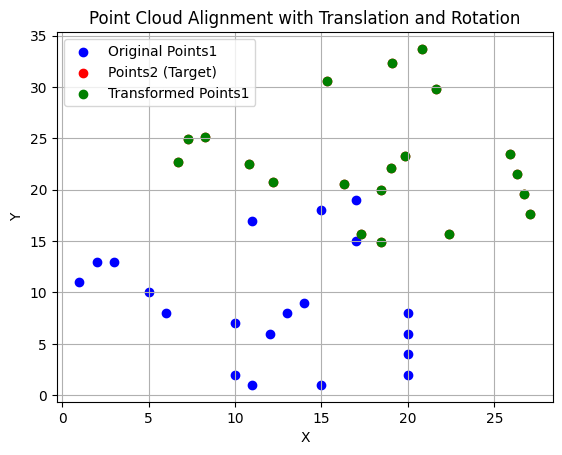

In [239]:
import numpy as np

def procrustes_analysis(points1, points2):
    """
    Perform Procrustes analysis to find the optimal rotation and translation
    that aligns points1 to points2.

    Parameters:
    points1 (np.ndarray): The first set of points (N x 2).
    points2 (np.ndarray): The second set of points (N x 2).

    Returns:
    np.ndarray: The transformed points1.
    np.ndarray: The rotation matrix.
    np.ndarray: The translation vector.
    """
    # Center the points by subtracting the centroid
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2

    # Compute the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(np.dot(centered_points2.T, centered_points1))
    rotation_matrix = np.dot(U, Vt)

    # Compute the translation vector
    translation_vector = centroid2 - np.dot(centroid1, rotation_matrix.T)

    # Apply the transformation
    transformed_points1 = np.dot(points1, rotation_matrix.T) + translation_vector

    return transformed_points1, rotation_matrix, translation_vector

# Example point clouds
points1 = pc_1 # np.array([[1, 2], [3, 4], [5, 6]], dtype=np.float32)
points2 = pc_2 # np.array([[2, 3], [4, 5], [6, 7]], dtype=np.float32)

# Perform Procrustes analysis
transformed_points1, rotation_matrix, translation_vector = procrustes_analysis(points1, points2)

print("Transformed Points1:\n", transformed_points1)
print("Rotation Matrix:\n", rotation_matrix)
print("Translation Vector:\n", translation_vector)

# Plot the original and transformed point clouds
import matplotlib.pyplot as plt

plt.scatter(points1[:, 0], points1[:, 1], color='blue', label='Original Points1')
plt.scatter(points2[:, 0], points2[:, 1], color='red', label='Points2 (Target)')
plt.scatter(transformed_points1[:, 0], transformed_points1[:, 1], color='green', label='Transformed Points1')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Cloud Alignment with Translation and Rotation')
plt.grid(True)
plt.show()
